# Monge, Bregman and Occam:
# Interpretable Optimal Transport in High-Dimensions with Feature-Sparse Maps

Based on the research paper : https://proceedings.mlr.press/v202/cuturi23a.html

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import jax
import jax.numpy as jnp
import jax.random as random

import ott

from ott.geometry.pointcloud import PointCloud
from ott.problems.linear.linear_problem import LinearProblem
from ott.solvers.linear.sinkhorn import Sinkhorn

from ott.geometry.costs import ElasticL1, SqEuclidean, ElasticSTVS, ElasticSqKOverlap

#### Monge Optimal Transport Problem

We consider a $\textit{translation-invariant}$ cost function $c(x,y) := h(x-y)$ where $h : \mathbb{R}^{d} \longrightarrow \mathbb{R}$. The Monge problem is the following optimisation problem :
$$ T^{*} := \arg\limits_{T \sharp \mu = \nu} \inf { \int_{\mathbb{R}^{d}} h(x - T(x)) d\mu(x) } $$
With $\forall A \subset \mathbb{R}^{d}, \: T \sharp \mu(A) = \mu(T^{-1}(A))$ 

In our case, we will consider $h$ of elastic type with the following form : $\forall z \in \mathbb{R}^{d}, \: h(z) := \frac{1}{2} \|z\|^2 + \tau(z)$ where $\tau$ is a function whose proximal operator is well defined and we will explain later why this condition is important.
$$ \text{remind that } \; \forall z \in \mathbb{R}^{d}, \: \mathbf{prox}_{\tau}(z) = \arg\limits_{x \in \mathbb{R}^{d}} \inf \left( \tau(x) + \frac{1}{2}\| x - z \|^{2} \right) $$
In this tutorial, we will restrict ourself to the following functions $\tau$ which are pretty simple and implemented (with their gradient, proximal operator, ...) optimally in OTT JAX :

1) Euclidian Case without any regularization : $\tau(z) = 0$, associated cost function $h$ will be `SqEuclidean`

2) $\ell_1$ regularization : $\tau(z) = \gamma \| z \|_{1}$, associated cost function $h$ will be `ElasticL1`

3) Soft Thresholding Vanishing Shrinkage (STVS) : $\tau(z) = \gamma^{2} \mathbf{1}_{d}^{T}\left( \text{asinh}(\frac{z}{2\gamma}) + \frac{1}{2} - \frac{1}{2}e^{-2\text{asinh}(\frac{z}{2\gamma})} \right)$, associated cost function $h$ will be `ElasticSTVS`

4) $k-$ Overlap : $\tau(z) = \| z \|_{\text{ov}k}$, associated cost function $h$ will be `ElasticSqKOverlap`

#### The aim of the paper is to establish a consistant estimator $T_{h,\varepsilon}$ of $T^{*}$, and to furnish this estimator, we will follow the following steps

### **Explained steps in the $ \ell_1- $ Norm regularization case** 

#### Step 1 : Context of the synthetic experiment
##### In this tutorial, we wanted to explain some functions of OTT JAX and to illustrate this, we wanted to reproduce the Synthetic experiments in case of Constant sparsity-pattern which has been studied in the article

We consider the following distributions: 

- $ \mu = \mathcal{U}_{[0,1]^d}$ ;
- For an integer $ s<d $, we set $ \nu = T^\star_s \sharp \mu \, , \, T^\star_s(x) = [\exp(x_1), \ldots, \exp(x_s), x_{s+1}, \ldots, x_d] $ where the map $ T^\star_s $ acts on coordinates independently.

We then generate $n$ i.i.d. samples $x_i$ from $\mu$, and $y_j$ from $\nu$ independently. The samples $y_j$ are obtained by first generating fresh i.i.d. samples $\tilde{x}_j$ from $\mu$ and then pushing them: $y_j := T^\star_s(\tilde{x}_j)$.

In [2]:
rngs = jax.random.split(jax.random.PRNGKey(0), 2)

# d,s and n are defined as follows
d, s, n = 2, 1, 7

# We first set x and x_tilde independently
X = jax.random.uniform(rngs[0], (n, d))
X_tilde = jax.random.uniform(rngs[1], (n, d))

# We then compute y from x_tilde
Y = jnp.hstack((jnp.exp(X_tilde[:, :s]), X_tilde[:, s:]))

# We also consider T* which is the push forward of X
T_star = jnp.hstack((jnp.exp(X[:, :s]), X[:, s:]))

2024-05-03 12:24:28.592281: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Here is what those randomly generated samples look like in a 2D space.

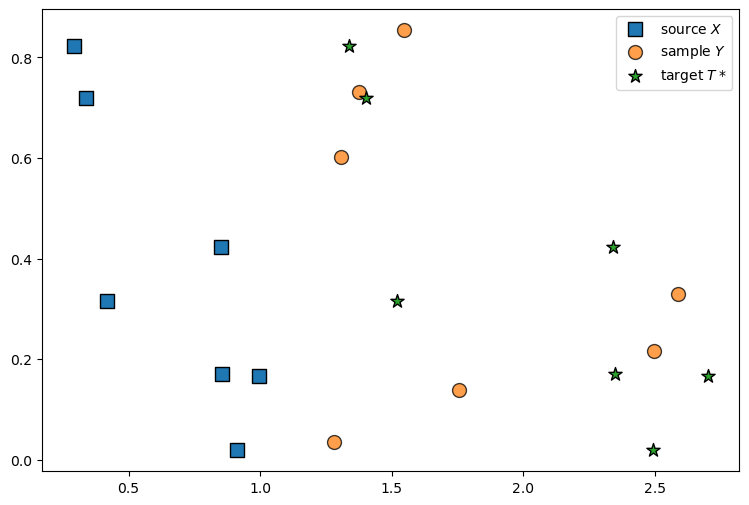

In [3]:
X_args = {"s": 100, "label": r"source $X$", "marker": "s", "edgecolor": "k"}
Y_args = {"s": 100, "label": r"sample $Y$", "edgecolor": "k", "alpha": 0.75}
T_star_args = {"s": 100, "label": r"target $T*$", "edgecolor": "k", "marker": "*"}
plt.figure(figsize=(9, 6))
plt.scatter(X[:, 0], X[:, 1], **X_args)
plt.scatter(Y[:, 0], Y[:, 1], **Y_args)
plt.scatter(T_star[:, 0], T_star[:, 1], **T_star_args)
plt.legend()
plt.show()

Now we'll start to set our problem with the `ott-jax` functions.

In [4]:
# We'll consider more and bigger samples
d, s, n = 100, 5, 1000
# Let's rewrite the points
X = jax.random.uniform(rngs[0], (n, d))
X_tilde = jax.random.uniform(rngs[1], (n, d))
Y = jnp.hstack((jnp.exp(X_tilde[:, :s]), X_tilde[:, s:]))
T_star = jnp.hstack((jnp.exp(X[:, :s]), X[:, s:]))
# For the following, we will introduce a regularisation parameter gamma
gamma = 0.01

In [5]:
# Define an euclidean geometry with the cost ElasticL1
geom_l1 = PointCloud(x=X, y=Y, 
                     cost_fn=ElasticL1(scaling_reg = gamma))
# Define the linear problem
problem_l1 = LinearProblem(geom_l1)

#### Step 2 : Dual Entropy-Regularized Optimal Transport Problem with 
One can show that to build $T_{h,\varepsilon}$, the only optimization problem we need to solve is the following one. This problem is known under the name of Dual Entropy-Regularized Optimal Transport Problem and the method we will use to solve it with OTT JAX is the Sinkhorn algorithm which is already implemented :
$$ f^{*} , g^{*} = \arg\limits_{f \in \mathbb{R}^{n} , g \in \mathbb{R}^{m}} \max \left\{ \left\langle f , \frac{\mathbf{1}_{n}}{n} \right\rangle + \left\langle g , \frac{\mathbf{1}_{m}}{m} \right\rangle - \varepsilon \left\langle e^{\frac{f}{\varepsilon}} , K e^{\frac{g}{\varepsilon}} \right\rangle \right\} $$
Where $K$ is the Kernel-Matrix defined by : $K_{i,j} := \left( \frac{ \exp\left( -h\left( x^{i} - y^{j} \right) \right) }{\varepsilon} \right)$ and $\left(x,y\right)$ the point cloud we will use

In [6]:
# We'll use a Sinkhorn solver, based on the algorithm of the same name
solver = Sinkhorn()
out_l1 = solver(problem_l1)
# Conversion into DualPotential object
entropic_map_l1 = out_l1.to_dual_potentials()

#### Step 3 : Gibbs distribution on the $m-$ simplex
Let's define the following set :
$$ \Omega_{\hat{\nu}_{m}}(h) := \left\{ x \; \vert \; \forall j \leq m, \: \nabla h ( x - y^{j} ) \; \text{exists} \right\} $$
When we get the dual potential $f^{*} , g^{*}$, one can compute the following weight function which will be useful to construct the estimator $T_{h,\varepsilon}$ :
$$ \forall x \in \Omega_{\hat{\nu}_{m}}(h), \: p^{j}(x) := \frac{ \exp\left( - \frac{h(x - y^{j}) - g_{j}^{*}}{\varepsilon} \right) }{ \sum\limits_{k=1}^{m}\exp\left( - \frac{h(x - y^{k}) - g_{k}^{*}}{\varepsilon} \right) } $$

#### Step 4 : Construction of $T_{h,\varepsilon}$ using the Proposition 4.1 of the article
Here, we see the importance of the previous steps, especially the fact that $\tau$ must have a proximal operator well defined
$$ \forall x \in \Omega_{\hat{\nu}_{m}}(h), \: T_{h,\varepsilon}(x) := x - \mathbf{prox}_{\tau}\left( x - \sum\limits_{j=1}^{m}p^{j}(x)\left( y^{j} - \nabla \tau \left( x - y^{j} \right) \right) \right) $$

In [7]:
# Getting exactly the T_{h,\varepsilon} estimator
T_l1 = entropic_map_l1.transport(X)

#### With these steps, we are able to construct the $T_{h,\varepsilon}$ estimator of $T^{*}$ for our translation invariant cost function $h$ :  in our case it is `T_l1`

In order to get the graphics presented in the paper, we will compute the Normalized NMSE and the SE of our estimator, which are defined below :
$$ \mathbf{NMSE}\left( T_{h,\varepsilon} \right) := \frac{1}{nd}\sum\limits_{i=1}^{n} \| T_{s}^{*}(x^{i}) - T_{h,\varepsilon}(x^{i}) \|^{2} $$
$$ \mathbf{SE}\left( T_{h,\varepsilon} \right) := \frac{ \sum\limits_{i=s+1}^{d} \Delta_{i}^{2} }{ \sum\limits_{i=1}^{d} \Delta_{i}^{2} } $$
With $\Delta := T_{h,\varepsilon}(x) - x$

In [8]:
# Calculating squared Euclidean distances between T_star and T_elastic_l1
squared_errors_l1 = jnp.linalg.norm(T_star - T_l1, axis=1)**2
# Computing the normalized NMSE
nmse_l1 = jnp.mean(squared_errors_l1) / T_star.shape[1]

# We compute the SE between T_elastic_l1 and X
se_l1 = jnp.mean(jnp.sum((T_l1[:, s+1:] - X[:, s+1:]) ** 2, axis=1) \
                 / jnp.sum((T_l1 - X) ** 2, axis=1))

# Results
print("NMSE for l1 norm :", nmse_l1)  # Expected NMSE around : 0.0664648
print("SE for l1 norm :", se_l1)    # Expected SE around : 0.42631245

NMSE for l1 norm : 0.0664648
SE for l1 norm : 0.42631245


### **Computations for all the different regularization cases** 

## Experiment

First, we will need to generate a certain number of samples with specific parameters.

In [9]:
# This first function will return X, Y and T*(X).
def generate_points(n, d, s):
    rngs = jax.random.split(jax.random.PRNGKey(0), 2)
    X = jax.random.uniform(rngs[0], (n, d))
    X_tilde = jax.random.uniform(rngs[1], (n, d))
    Y = jnp.hstack((jnp.exp(X_tilde[:, :s]), X_tilde[:, s:]))
    T_star = jnp.hstack((jnp.exp(X[:, :s]), X[:, s:]))
    return X, Y, T_star

Then let's write a general function to compute the NMSE and SE. It will take as an input our sets of points, a regularization parameter $\gamma$ and a cost function.

In [10]:
def compute_nmse_se(n, d, s, cost_fn, gamma=None, k=None):
    X, Y, T_star = generate_points(n, d, s)
    # Each cost functions doesn't necessaraly take the same arguments
    if k != None:
        geom = PointCloud(x=X, y=Y, 
                cost_fn=cost_fn(scaling_reg=gamma, k=k))
    elif gamma != None:
        geom = PointCloud(x=X, y=Y, 
                cost_fn=cost_fn(scaling_reg=gamma))
    else: 
        geom = PointCloud(x=X, y=Y, cost_fn=cost_fn)
    problem = LinearProblem(geom)
    # Solver
    out = Sinkhorn()(problem)
    entropic_map = out.to_dual_potentials()
    T_h_eps = entropic_map.transport(X)
    # Computing NMSE
    squared_errors = jnp.linalg.norm(T_star - T_h_eps, axis=1)**2
    nmse = jnp.mean(squared_errors) / T_star.shape[1]
    # Computing SE
    se = jnp.mean(jnp.sum((T_h_eps[:, s+1:] - X[:, s+1:]) ** 2, axis=1) \
                     / jnp.sum((T_h_eps - X) ** 2, axis=1))
    return nmse, se

### Application

For the following, we will try to find the best value for our regularization parameter $\gamma$.

We will consider 1000 i.i.d points $x^i$ and $y^j$, the dimension $d \in \{ 8, 20, 100 \}$, $s=5$, such that $s<<d$, and $\gamma \in [10^{-2}, 10^{2}]$.

In [ ]:
# It might take a long time to run this cell
# Parameters
n = 1000
d_list = [8, 20, 100]
s = 5
gamma_list = jnp.logspace(-2, 2, num=40, base=10)

dfs_l1 = []
dfs_l2 = []
dfs_stvs = []
dfs_ovk_k5 = []
dfs_ovk_k7 = []

for d in d_list:
    # Elastic L1 model
    results_l1 = []
    for gamma in gamma_list:
        nmse, se = compute_nmse_se(n, d, s, ElasticL1, gamma)
        results_l1.append([gamma, nmse, se])
    dfs_l1.append(pd.DataFrame(results_l1, columns=['gamma', 'NMSE', 'SE']))
    
    # L2 norm Model
    nmse, se = compute_nmse_se(n, d, s, SqEuclidean())
    results_l2 = [[gamma, nmse, se] for gamma in gamma_list]
    dfs_l2.append(pd.DataFrame(results_l2, columns=['gamma', 'NMSE', 'SE']))
    
    # Elastic STVS Model
    results_stvs = []
    for gamma in gamma_list:
        nmse, se = compute_nmse_se(n, d, s, ElasticSTVS, gamma)
        results_stvs.append([gamma, nmse, se])
    dfs_stvs.append(pd.DataFrame(results_stvs, columns=['gamma', 'NMSE', 'SE']))
    
    # Elastic OVK for k=5 and k=7
    for k in [5, 7]:
        results_ovk = []
        for gamma in gamma_list:
            nmse, se = compute_nmse_se(n, d, s, ElasticSqKOverlap, gamma, k)
            results_ovk.append([gamma, nmse, se])
        if k == 5:
            dfs_ovk_k5.append(pd.DataFrame(results_ovk, columns=['gamma', 'NMSE', 'SE']))
        else:
            dfs_ovk_k7.append(pd.DataFrame(results_ovk, columns=['gamma', 'NMSE', 'SE']))

#### Plots :

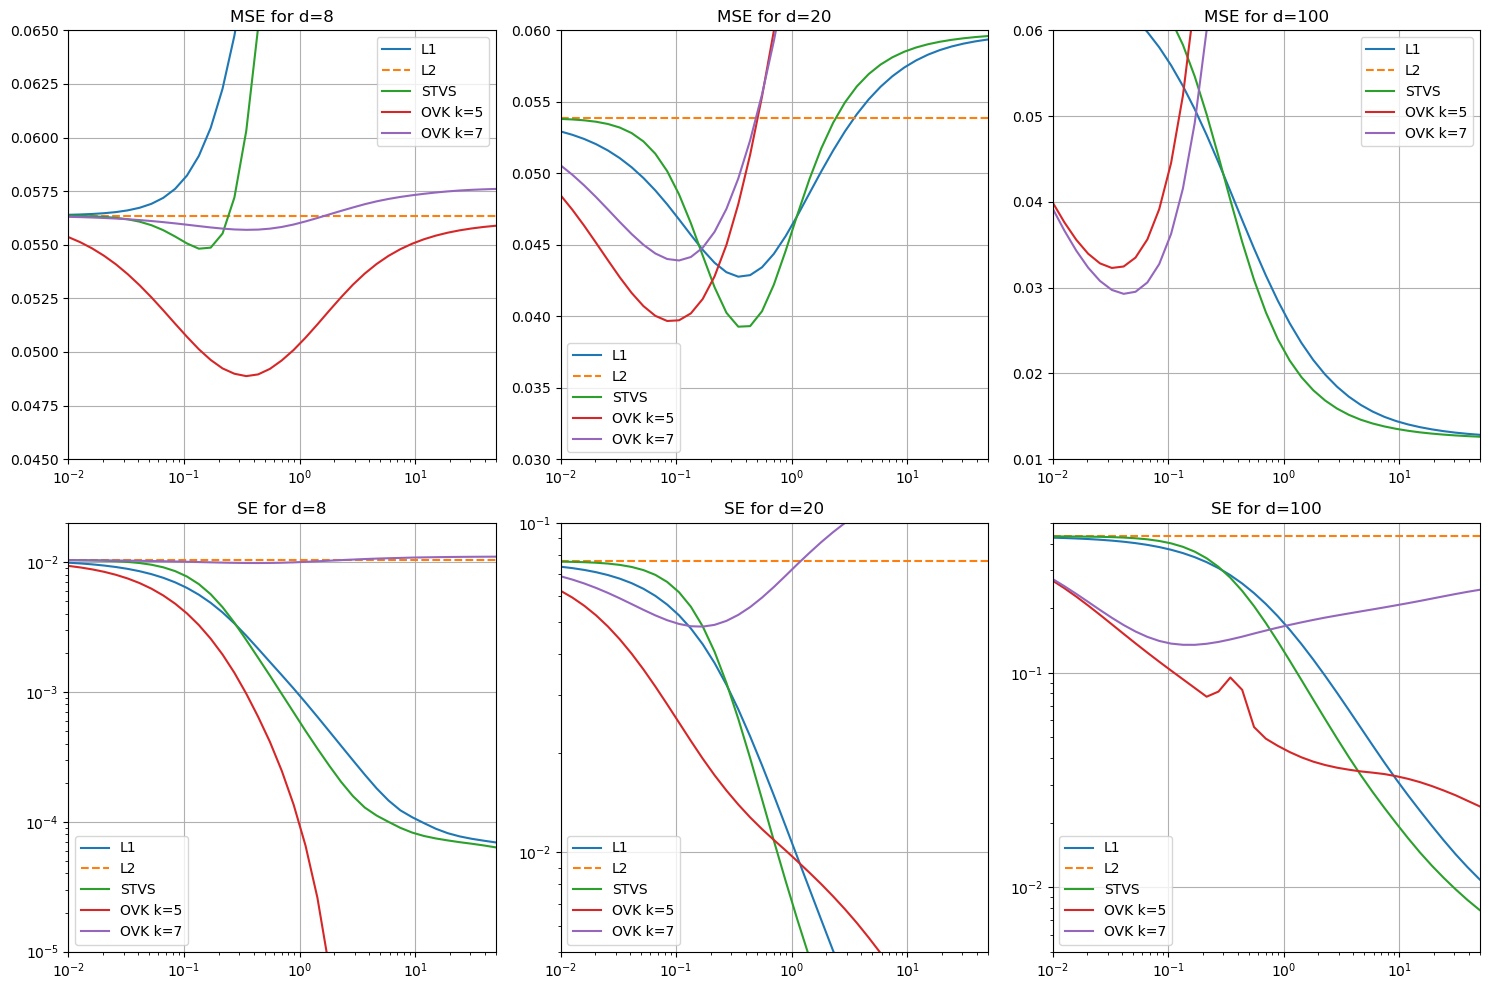

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
y_lim_NMSE = [[0.045,0.065], [0.03,0.06], [0.01,0.06]]

# Plots for NMSE
for i, (df_l1, df_l2, df_stvs, df_ovk_k5, df_ovk_k7) in \
    enumerate(zip(dfs_l1, dfs_l2, dfs_stvs, dfs_ovk_k5, dfs_ovk_k7)):
    ax = axes[0, i]
    ax.plot(df_l1['gamma'], df_l1['NMSE'], label='L1')
    ax.plot(df_l2['gamma'], df_l2['NMSE'], linestyle='--', label='L2')
    ax.plot(df_stvs['gamma'], df_stvs['NMSE'], label='STVS')
    ax.plot(df_ovk_k5['gamma'], df_ovk_k5['NMSE'], label='OVK k=5')
    ax.plot(df_ovk_k7['gamma'], df_ovk_k7['NMSE'], label='OVK k=7')
    ax.set_title(f"d={d_list[i]}")
    ax.legend()
    ax.grid(True)
    ax.set_xscale('log')
    ax.set_xlim(0.01, 50)  
    ax.set_ylim(y_lim_NMSE[i][0], y_lim_NMSE[i][1])

# Plots for SE
y_lim_SE = [[1e-5,0.02], [5e-3,0.1], [0.005,0.5]]
for i, (df_l1, df_l2, df_stvs, df_ovk_k5, df_ovk_k7) in \
    enumerate(zip(dfs_l1, dfs_l2, dfs_stvs, dfs_ovk_k5, dfs_ovk_k7)):
    ax = axes[1, i]
    ax.plot(df_l1['gamma'], df_l1['SE'], label='L1')
    ax.plot(df_l2['gamma'], df_l2['SE'], linestyle='--', label='L2')
    ax.plot(df_stvs['gamma'], df_stvs['SE'], label='STVS')
    ax.plot(df_ovk_k5['gamma'], df_ovk_k5['SE'], label='OVK k=5')
    ax.plot(df_ovk_k7['gamma'], df_ovk_k7['SE'], label='OVK k=7')
    ax.legend()
    ax.grid(True)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(0.01, 50)
    ax.set_ylim(y_lim_SE[i][0], y_lim_SE[i][1])  

for ax, title in zip(axes[0], ['d=8', 'd=20', 'd=100']):
    ax.set_title("NMSE for " + title)

for ax, title in zip(axes[1], ['d=8', 'd=20', 'd=100']):
    ax.set_title("SE for " + title)

fig.tight_layout()
plt.show()

### Scaling with dimensions

Now, we are going to compute the NMSE while varying the dimension $d$. For that, we need to chose a value for $\gamma$.

In this simulation, we will consider $n=100$, $s=2$ and $d \in [7,1000]$. 

In [ ]:
# Parameters
n = 100
d_list = jnp.logspace(jnp.log10(8), jnp.log10(1000), num=20, dtype=int)
s = 2
gamma_list = jnp.logspace(-2, 2, num=40, base=10)
models = {'L1' : ElasticL1, 'L2': SqEuclidean(), 'STVS': ElasticSTVS, 'OVK_k5': ElasticSqKOverlap, 'OVK_k7': ElasticSqKOverlap}

In [ ]:
# This is the longest cell to run
# To save the values of our NMSE depending on d for each model
plot_data = {model: [] for model in models.keys()}

for model in models.keys():
    # The first steps are similar to before, 
    # but here we only keep our NMSE while varying gamma
    for d in d_list:
        temp_results = []
        k = None
        for gamma in gamma_list:
            # We compute our NMSE and SE for each gamma
            if model == 'L2':
                nmse, se = compute_nmse_se(n, d, s, SqEuclidean())
            elif model.startswith('OVK_k'):
                k = int(model.split('k')[1])
                nmse, se = compute_nmse_se(n, d, s, ElasticSqKOverlap, gamma, k)
            else:
                nmse, se = compute_nmse_se(n, d, s, \
                        ElasticL1 if model == 'L1' else ElasticSTVS, gamma)
            # But we only keep our NMSE
            temp_results.append([gamma, nmse])
        df = pd.DataFrame(temp_results, columns=['gamma', 'NMSE'])
        # We then look for the gamma that minimizes NMSE
        min_nmse_index = df['NMSE'].idxmin()
        optimal_gamma = df.loc[min_nmse_index, 'gamma']
        if model == 'L2':
            optimal_gamma = None
        # In the same time, we can already compute our NMSE with this optimal gamma
        nmse, se = compute_nmse_se(n, d, s, models[model], optimal_gamma, k)
        # Lastly, we keep track of our results
        plot_data[model].append([d, nmse])

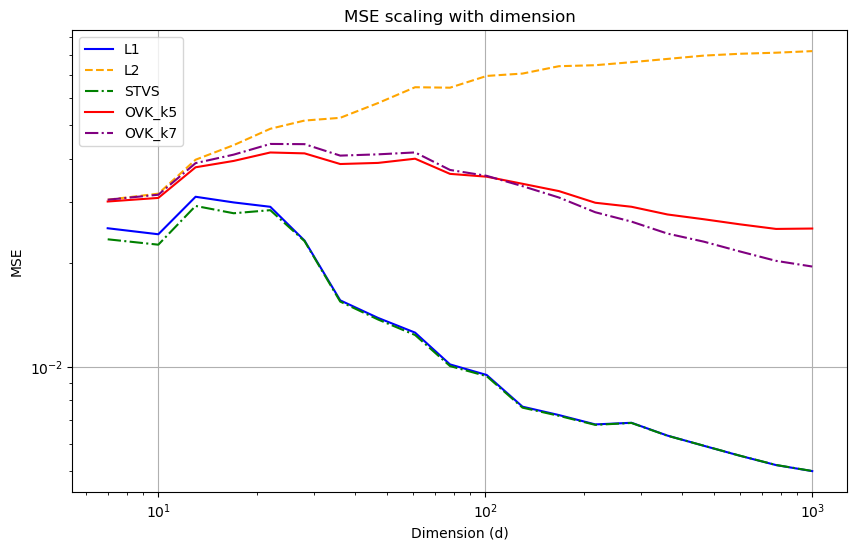

In [ ]:
# DataFrame for the final plot
plot_data = {model: pd.DataFrame(plot_data[model], columns=['d', 'NMSE']) for model in models}

plt.figure(figsize=(10, 6))
styles = {
    'L1': ('-', 'blue'),
    'L2': ('--', 'orange'),
    'STVS': ('-.', 'green'),
    'OVK_k5': ('-', 'red'),
    'OVK_k7': ('-.', 'purple')
}

for model, (style, color) in styles.items():
    plt.plot(plot_data[model]['d'], plot_data[model]['NMSE'], linestyle=style, color=color, label=model)

plt.xlabel('Dimension (d)')
plt.ylabel('NMSE')
plt.xscale('log')
plt.yscale('log')
plt.title('NMSE scaling with dimension')
plt.legend()
plt.grid(True)
plt.show()